# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
# Uncomment and run to install dependencies 
# !pip -q install ./python/

### Testing the environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from env_loader import get_env

# Change the path on this line to the environment file
file_path = "Banana.x86_64"
env, brain_name, action_size, state_size = get_env(file_path)

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37
Score: 1.0


### Importing classes

As suggested I will take the classes from the previous lessons and adjust the hyperparameters to achieve the goal.

The classes I will use are:
- ReplayBuffer
- QNetwork
- Agent


In [3]:
# First lets centralize the imported modules

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
from collections import namedtuple, deque

import matplotlib.pyplot as plt

# ...and the global variables

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# The following 3 are defined above
# action_size = 4
# state_size = 37
# brain_name = brain_name

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

#### ReplayBuffer

This class will suffer no changes.

In a future version I may add a weight to each experience for a prioritized experience replay.

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### QNetwork

Modifications:
- Add one more layer
- Redistribute the neurons

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=100, fc2_units=100, fc3_units=100):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


#### Agent

In [6]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### Train the agent

First define the simulation function.

In [7]:
def dqn(agent, env, brain_name, train_mode=True, n_episodes=4000, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        state = env_info.vector_observations[0]                 # get the current state
        score = 0                                               # initialize the score
        done = False
        while not done:
            action = agent.act(state, eps)

            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
                        
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if train_mode:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=13.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'local_checkpoint.pth')
                torch.save(agent.qnetwork_target.state_dict(), 'target_checkpoint.pth')
                break
        else:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, score))
    return scores

In [8]:
agent = Agent(state_size, action_size)
scores = dqn(agent, env, brain_name)

Episode 100	Average Score: 0.35
Episode 200	Average Score: 2.71
Episode 300	Average Score: 7.12
Episode 400	Average Score: 9.23
Episode 500	Average Score: 12.70
Episode 510	Average Score: 13.04
Environment solved in 410 episodes!	Average Score: 13.04


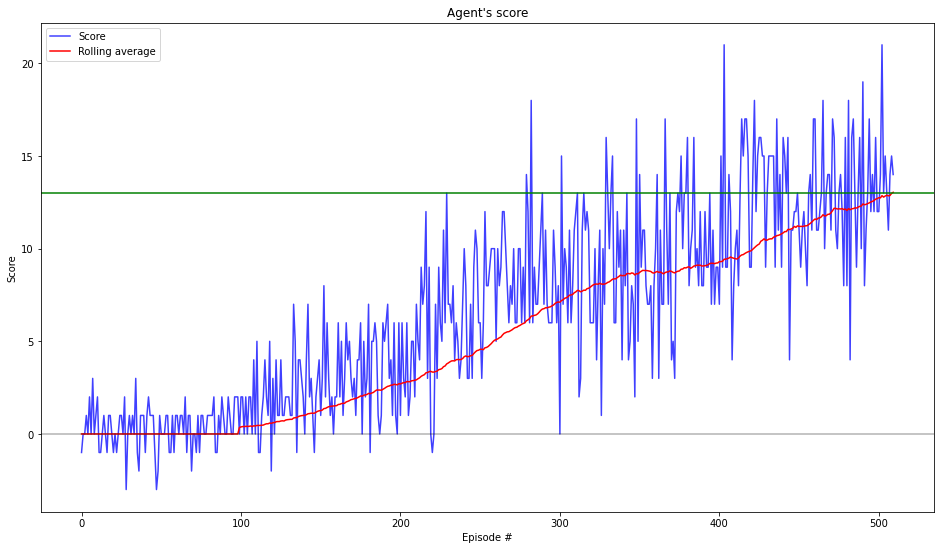

In [9]:
# plot the scores

# Compute the rolling average
rolling_avg = np.zeros(len(scores))
for i in range(99, len(scores)):
    rolling_avg[i] = np.mean(scores[i-99:i+1])

# Create a 16x9 figure
fig, ax = plt.subplots(figsize=(16,9))

# Plot both curves over the same axis
ax.plot(range(len(scores)), scores, label='Score', color='blue', alpha=0.75)
ax.plot(range(len(rolling_avg)), rolling_avg, label='Rolling average', color='red')
ax.axhline(0, color='black', alpha=0.3)
ax.axhline(13, color='green')

ax.set_title('Agent\'s score')
ax.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('Score_over_train.png')
plt.show()

### See the trained agent in action

In [13]:
trained_agent = Agent(state_size, action_size)

trained_agent.qnetwork_local.load_state_dict(torch.load('mlocal_checkpoint.pth'))
trained_agent.qnetwork_target.load_state_dict(torch.load('mtarget_checkpoint.pth'))
# Uncomment this line to see the recently trained agent
# trained_agent.qnetwork_local.load_state_dict(torch.load('local_checkpoint.pth'))
# trained_agent.qnetwork_target.load_state_dict(torch.load('target_checkpoint.pth'))

dqn(trained_agent, env, brain_name, train_mode=False, n_episodes=10, eps_start=0.05)


Episode 1	Average Score: 7.00
Episode 2	Average Score: 7.00
Episode 3	Average Score: 8.00
Episode 4	Average Score: 16.00
Episode 5	Average Score: 2.00
Episode 6	Average Score: 6.00
Episode 7	Average Score: 12.00
Episode 8	Average Score: 12.00
Episode 9	Average Score: 9.00
Episode 10	Average Score: 16.00


[7.0, 7.0, 8.0, 16.0, 2.0, 6.0, 12.0, 12.0, 9.0, 16.0]

In [14]:
# Uncomment and run to close the environment
env.close()